# Importing Libraries

In [1]:
import warnings 
warnings.filterwarnings('ignore')

#Basic packages
import os
import pandas as pd
import numpy as np
import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import warnings
warnings.filterwarnings('ignore')

# Importing Data

In [2]:
train_df = pd.read_csv("salesprediction.csv")
train_df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [3]:
print(train_df['item'].unique())
print(train_df['store'].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
[ 1  2  3  4  5  6  7  8  9 10]


## Converting Date from string to datetime

In [4]:
train_df['date'] = pd.to_datetime(train_df['date'], format="%Y-%m-%d")

In [5]:
train_df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [6]:
# Expand dataframe with more useful columns
def expand_df(df):
    data = df.copy()
    
    data['day'] = data.date.dt.day
    data['month'] = data.date.dt.month
    data['year'] = data.date.dt.year
    data['dayofweek'] = data.date.dt.dayofweek #Monday=0,Sunday=6
    return data

train_df = expand_df(train_df)
display(train_df)

,date,store,item,sales,day,month,year,dayofweek
0,2013-01-01,1,1,13,1,1,2013,1
1,2013-01-02,1,1,11,2,1,2013,2
2,2013-01-03,1,1,14,3,1,2013,3
3,2013-01-04,1,1,13,4,1,2013,4
4,2013-01-05,1,1,10,5,1,2013,5
...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,27,12,2017,2
912996,2017-12-28,10,50,59,28,12,2017,3
912997,2017-12-29,10,50,74,29,12,2017,4
912998,2017-12-30,10,50,62,30,12,2017,5


# Data Visualisation

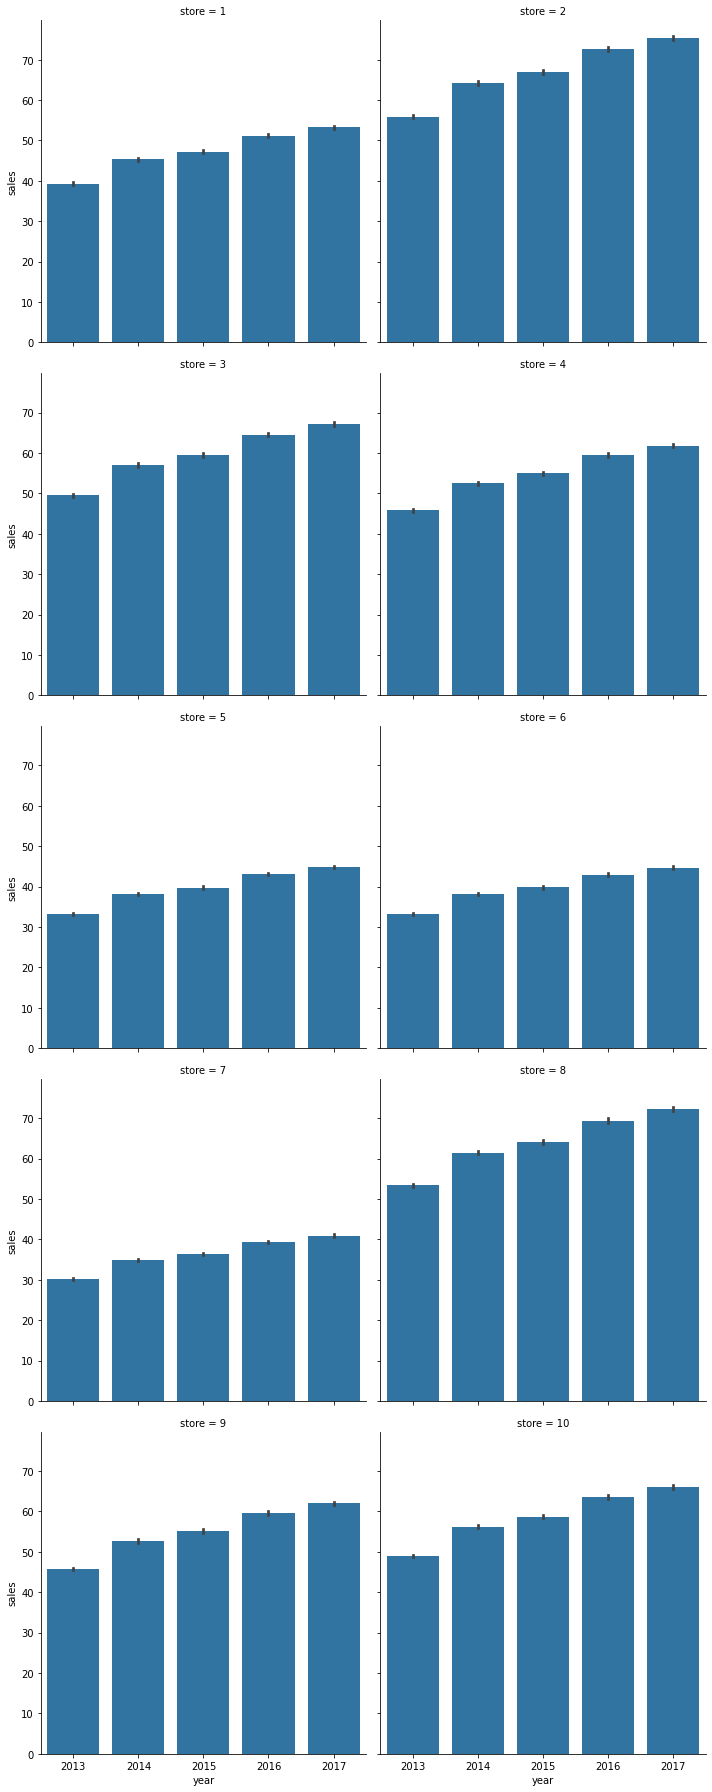

In [7]:
#sales at different stores
sales_bar=sns.FacetGrid(train_df,col="store", col_order=[1,2,3,4,5,6,7,8,9,10],col_wrap=2,size=5)
sales_bar.map(sns.barplot,"year","sales")

Every year there is increase in sales each store

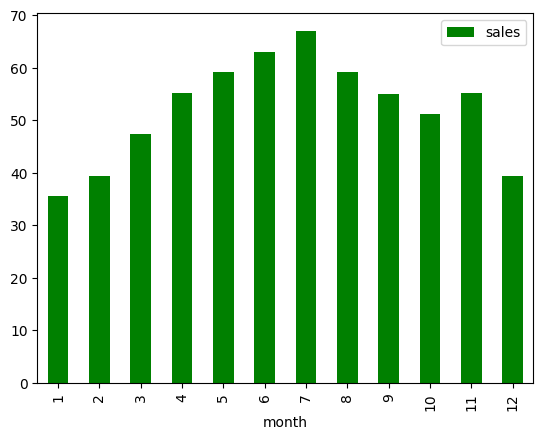

In [8]:
#Monthly total sales of stores
train_df[['sales','month']].groupby(["month"]).mean().plot.bar(color='g')
plt.show()

June,July & Aug have high sales

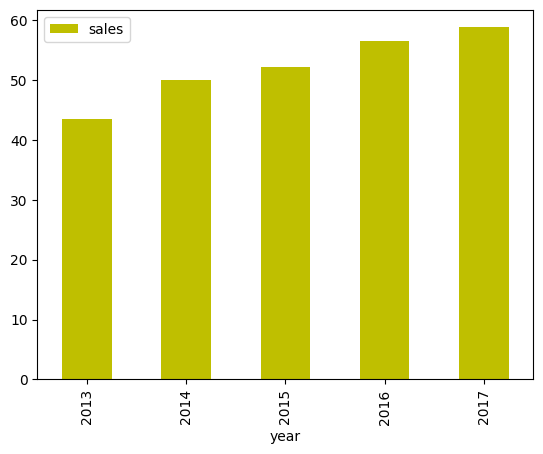

In [9]:
#Yearly total sales
train_df[['sales','year']].groupby(["year"]).mean().plot.bar(color='y')
plt.show()

Every year there is increase sales

## cheking missing values

In [10]:
train_df.isna().sum()

date         0
store        0
item         0
sales        0
day          0
month        0
year         0
dayofweek    0
dtype: int64

There is no missing value

## Setting Date as Index

In [11]:
train_df = train_df.set_index('date')
train_df.head()

,store,item,sales,day,month,year,dayofweek
date,,,,,,,
2013-01-01,1,1,13,1,1,2013,1
2013-01-02,1,1,11,2,1,2013,2
2013-01-03,1,1,14,3,1,2013,3
2013-01-04,1,1,13,4,1,2013,4
2013-01-05,1,1,10,5,1,2013,5


## Decomposing Time Series

<Figure size 640x480 with 0 Axes>

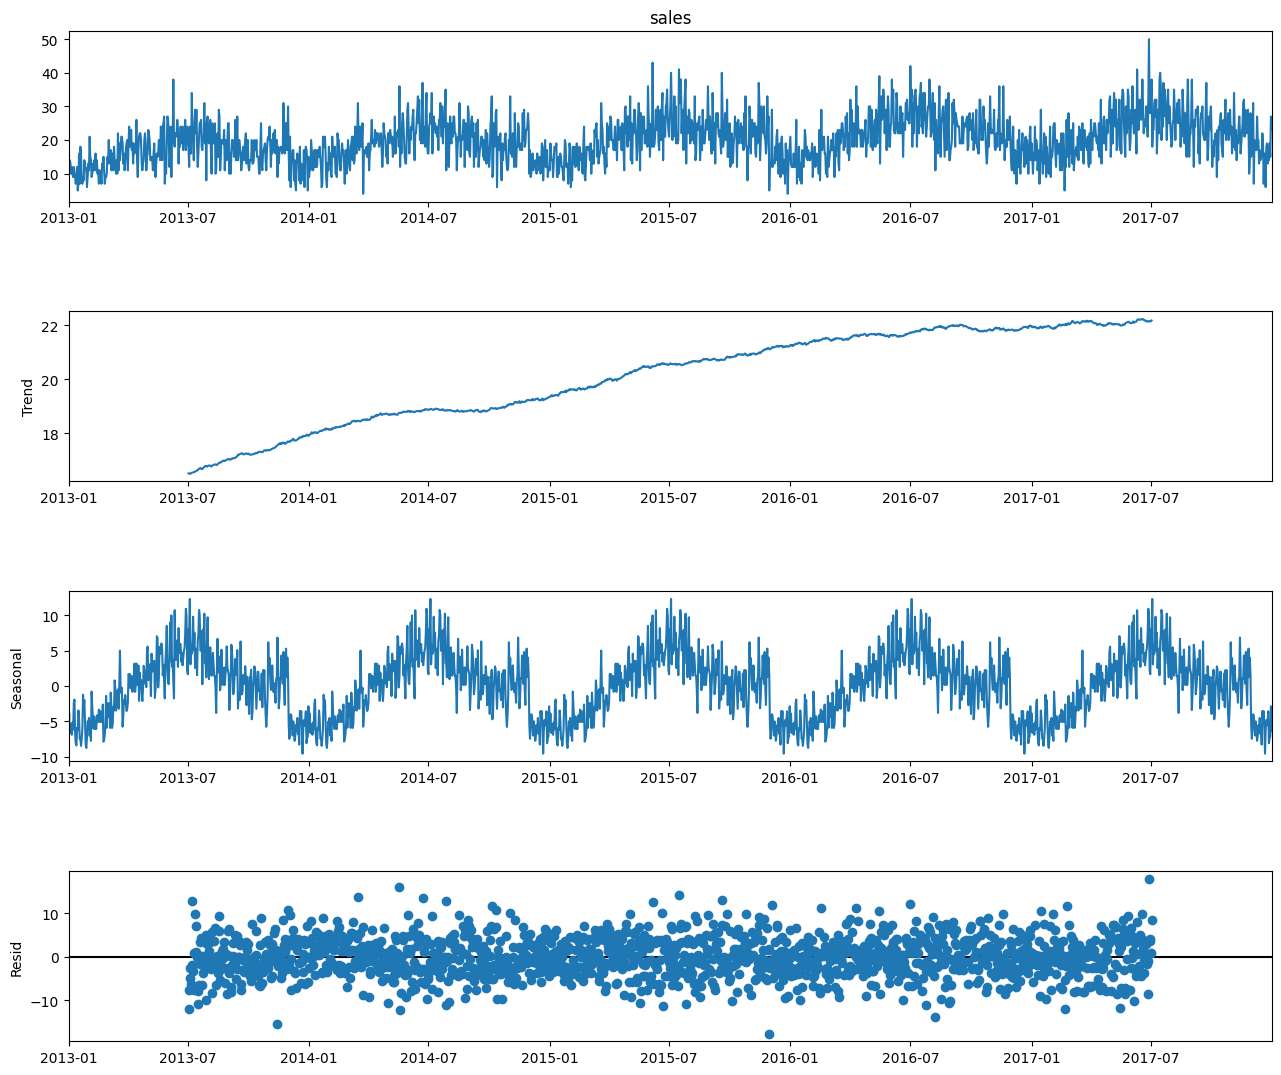

In [12]:
#Decomposing the data of smaller size. 
# Here I will take data having item and store equal to 1.
train_item1 = train_df[train_df['item']==1]
train_final = train_item1[train_item1['store']==1]

from statsmodels.tsa.seasonal import seasonal_decompose
result = sm.tsa.seasonal_decompose(train_final['sales'], model='additive', period=365) #Seasonal decomposition using moving averages

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)


# Checking Stationarity

Before applying any statistical model on a Time Series, the series has to be stationary or time invariant.
- The mean of the series should not be a function of time.
- The variance of the series should not be a function of time. This property is known as homoscedasticity.
- Finally, the covariance of the i th term and the (i + m) th term should not be a function of time.

Here we are going to check the stationarity using 2 methods:

## 1.Rolling mean Analysis

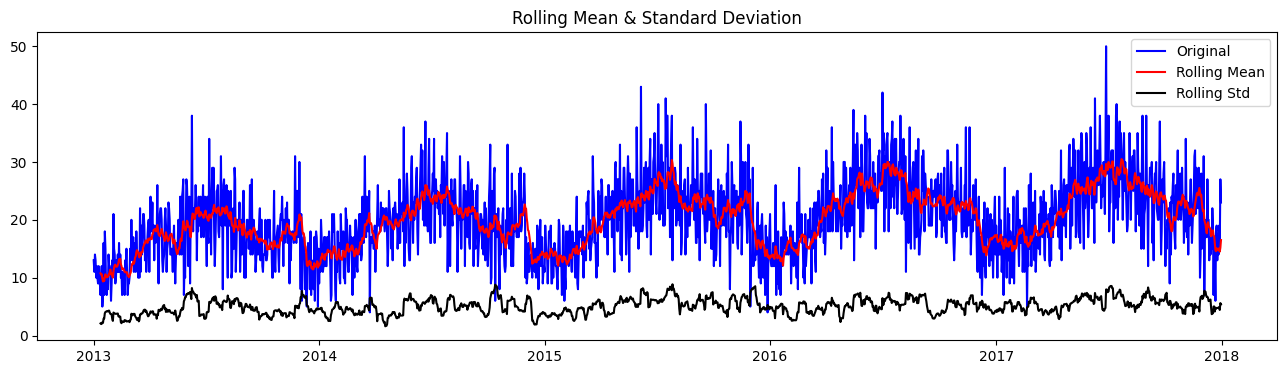

In [13]:
def roll_stats(timeseries, window = 12, cutoff = 0.01):
    
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(16, 4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
roll_stats(train_final['sales'])  


## 2.Dickey-Fuller test

In [14]:
def dickey_fuller_test(timeseries, window = 12, cutoff = 0.01):
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
dickey_fuller_test(train_final['sales'])

p-value = 0.0361. The series is likely non-stationary.
Test Statistic                   -2.987278
p-value                           0.036100
#Lags Used                       20.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64


## Convert the time series stationary

date
2013-01-02   -2.0
2013-01-03    3.0
2013-01-04   -1.0
2013-01-05   -3.0
2013-01-06    2.0
Name: sales, dtype: float64


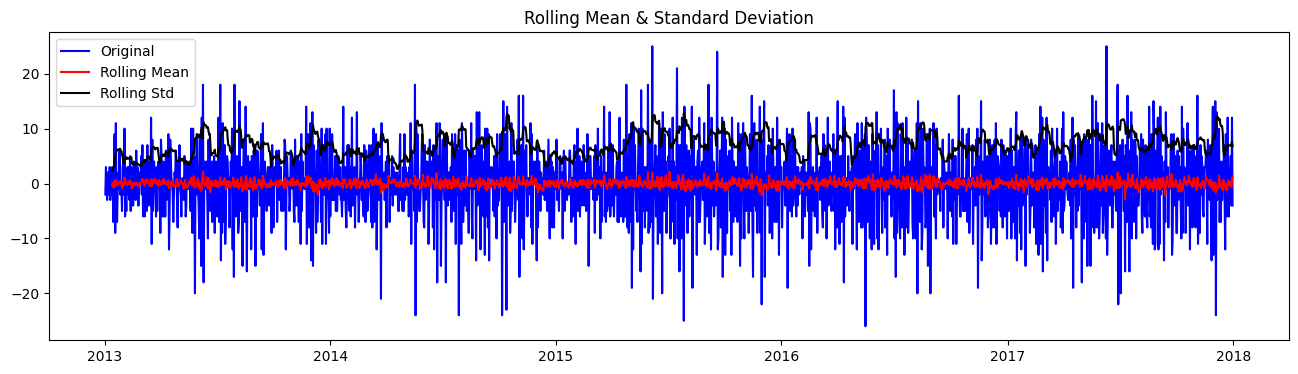

p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.520810e+01
p-value                        5.705031e-28
#Lags Used                     2.000000e+01
Number of Observations Used    1.804000e+03
Critical Value (1%)           -3.433980e+00
Critical Value (5%)           -2.863143e+00
Critical Value (10%)          -2.567624e+00
dtype: float64


In [15]:
first_diff = train_final.sales - train_final.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
print(first_diff.head())

roll_stats(first_diff,window = 12, cutoff = 0.01)
dickey_fuller_test(first_diff, window = 12)

**Now The time series data is Stationary**

# ACF and PACF charts

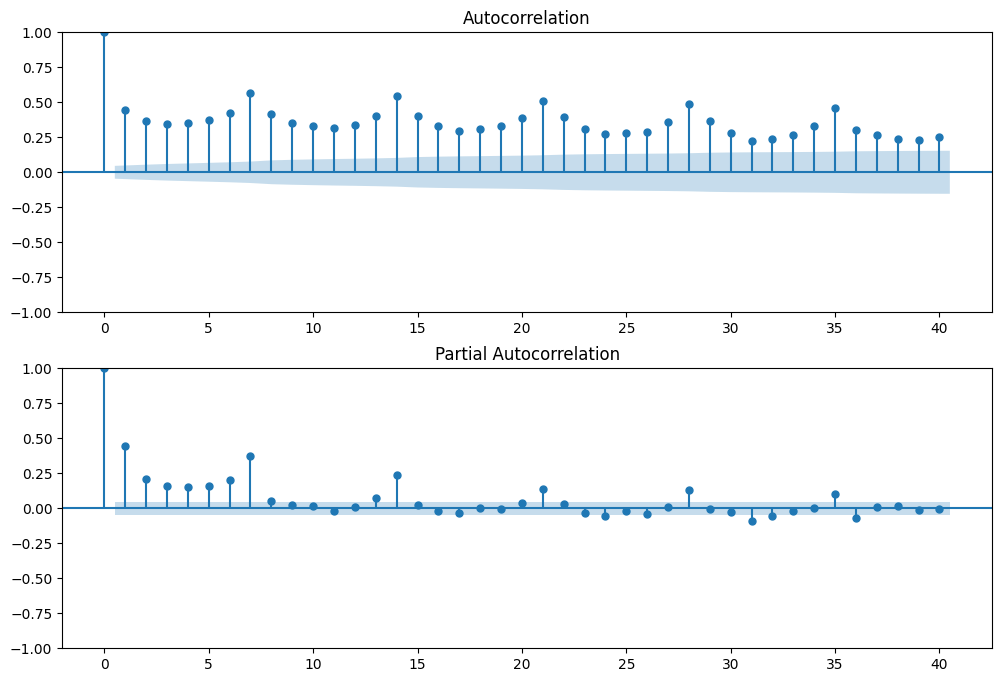

In [16]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_final.sales, lags=40, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_final.sales, lags=40, ax=ax2)     # lags=40

**After diffrencing :**

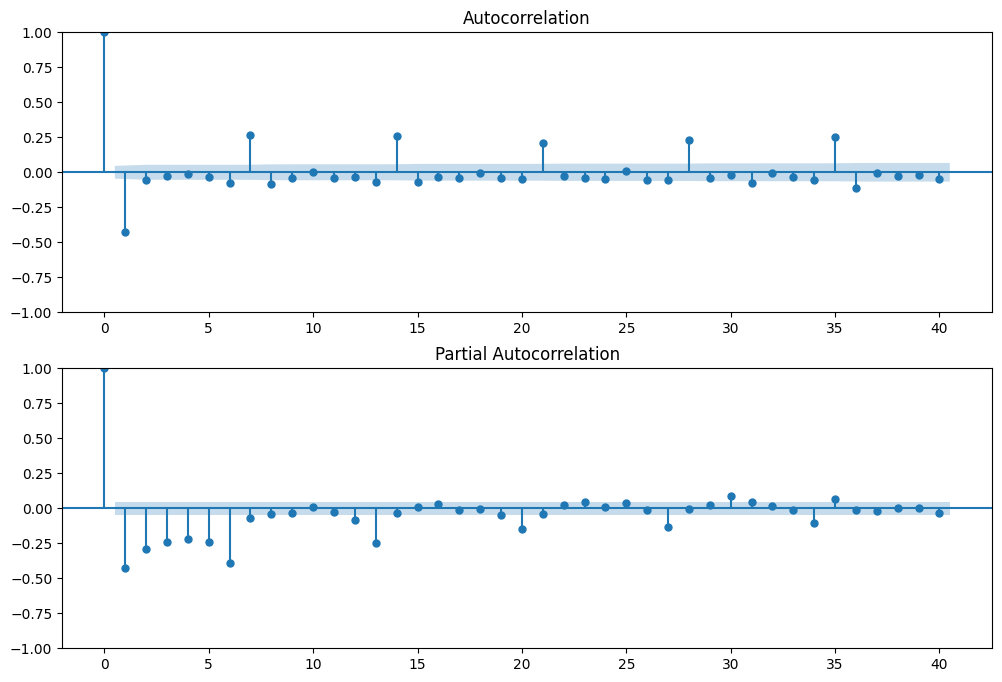

In [17]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

Here we can see the acf and pacf both has a recurring pattern every 7 periods. Indicating a weekly pattern exists.

## Determining order p, d, q through ACF/PACF plots:

We see the first order differencing make the ts stationary. I = 1.
<br> AR model might be investigated first with lag length selected from the PACF or via empirical investigation. In our case, it's clearly that within 6 lags the AR is significant. Which means, we can use **AR = 6**
<br>To avoid the potential for incorrectly specifying the MA order (in the case where the MA is first tried then the MA order is being set to 0), it may often make sense to extend the lag observed from the last significant term in the PACF.

# Order of the AR term (p)

In [18]:
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(train_final.sales, order = (6,1,0)).fit()
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1826
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -5597.679
Date:                Mon, 11 Jul 2022   AIC                          11209.359
Time:                        12:02:14   BIC                          11247.924
Sample:                    01-01-2013   HQIC                         11223.585
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8174      0.021    -39.063      0.000      -0.858      -0.776
ar.L2         -0.7497      0.025    -30.480      0.000      -0.798      -0.702
ar.L3         -0.6900      0.026    -26.686      0.0

In [19]:
'''from statsmodels.tsa.arima.model import ARIMA
arima_model1 = ARIMA(train_final.sales, order = (7,1,1)).fit()

print(arima_model1.summary())
'''

'from statsmodels.tsa.arima.model import ARIMA\narima_model1 = ARIMA(train_final.sales, order = (7,1,1)).fit()\n\nprint(arima_model1.summary())\n'

**Plot for Residual Distribution**

NormaltestResult(statistic=16.74269015078588, pvalue=0.000231404088367757)


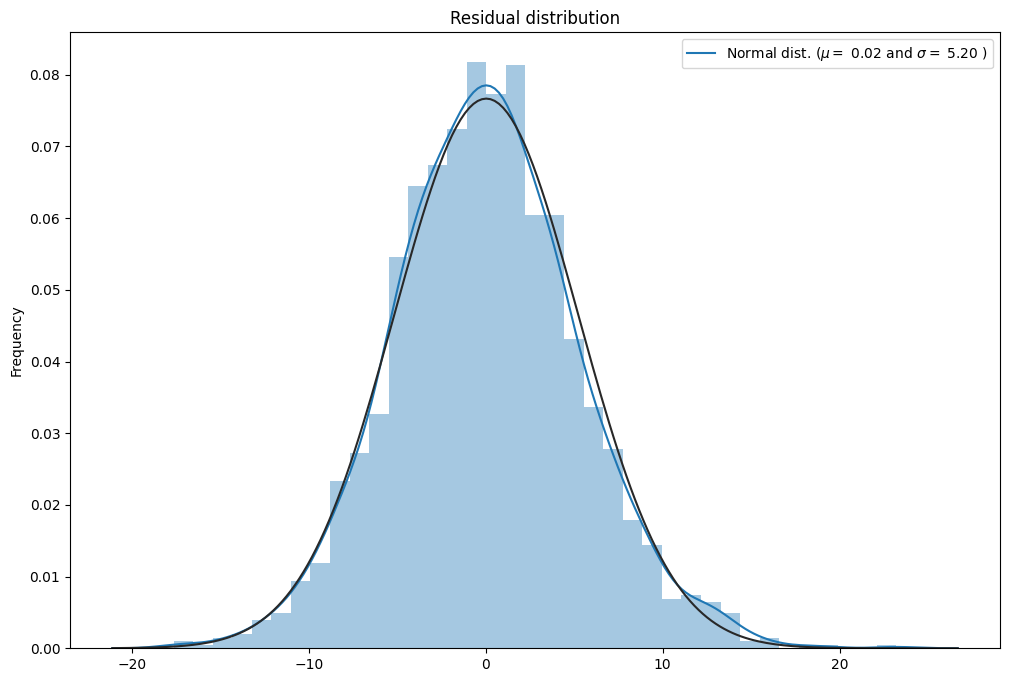

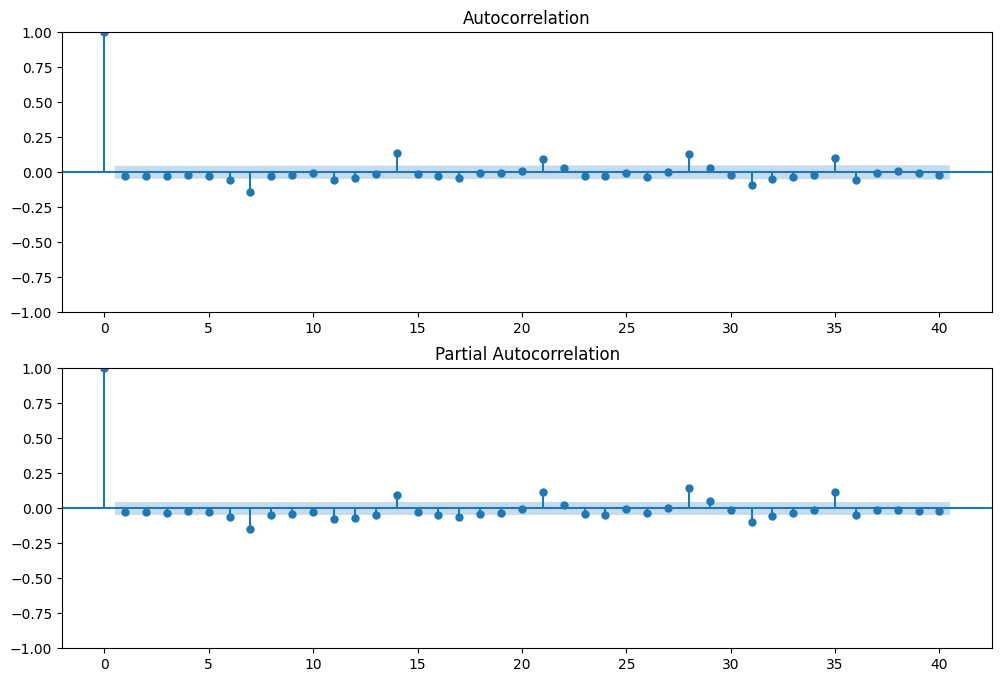

In [20]:
from scipy import stats
from scipy.stats import normaltest

resid = arima_model.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_model.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_model.resid, lags=40, ax=ax2)

Although the graph looks very like a normal distribution. But there is a recurring correlation exists in both ACF and PACF. So we need to deal with **seasonality**.

# Prediction using ARIMA Model

Take the last 30 days in training set as validation data

<AxesSubplot:xlabel='date'>

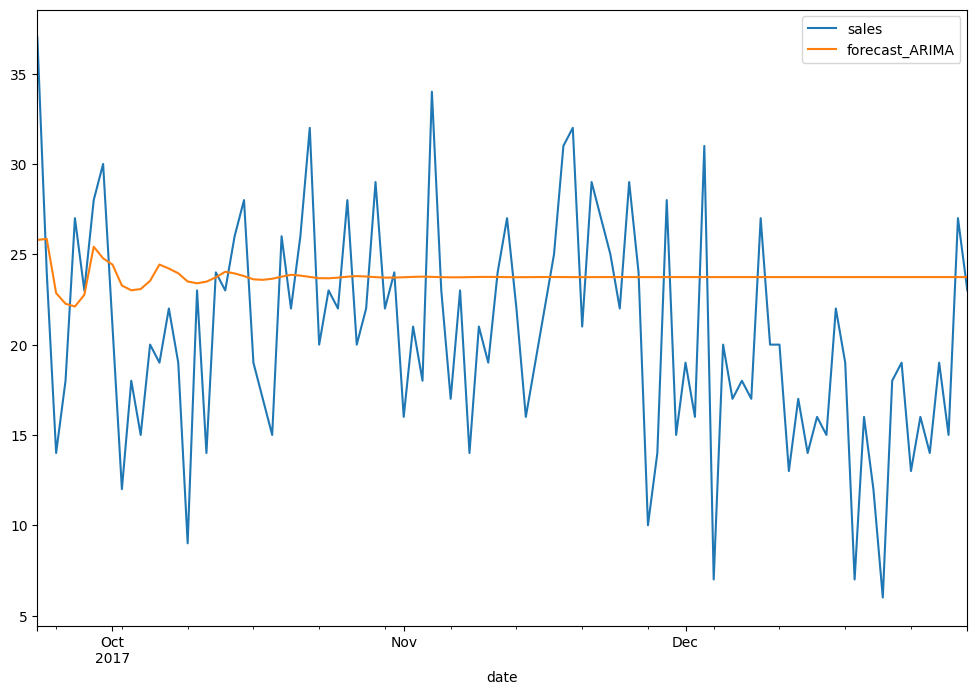

In [21]:
start_index = 1726
end_index = 1826
train_df['forecast_ARIMA'] = arima_model.predict(start = start_index, end= end_index, dynamic= True)  
train_df[start_index:end_index][['sales', 'forecast_ARIMA']].plot(figsize=(12, 8))

In [22]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

In [23]:
smape_kun(train_df[1730:1825]['sales'],train_df[1730:1825]['forecast_ARIMA'])

MAPE: 37.04 % 
SMAPE: 27.16 %


## Consider seasonality affect by SARIMA

In [24]:
#SARIMAX

sarima_model = sm.tsa.statespace.SARIMAX(train_final.sales, trend='n', order=(6,1,0)).fit()
print(sarima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1826
Model:               SARIMAX(6, 1, 0)   Log Likelihood               -5597.679
Date:                Mon, 11 Jul 2022   AIC                          11209.359
Time:                        12:02:24   BIC                          11247.924
Sample:                    01-01-2013   HQIC                         11223.585
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8174      0.021    -39.063      0.000      -0.858      -0.776
ar.L2         -0.7497      0.025    -30.480      0.000      -0.798      -0.702
ar.L3         -0.6900      0.026    -26.686      0.0

NormaltestResult(statistic=16.74269015078588, pvalue=0.000231404088367757)


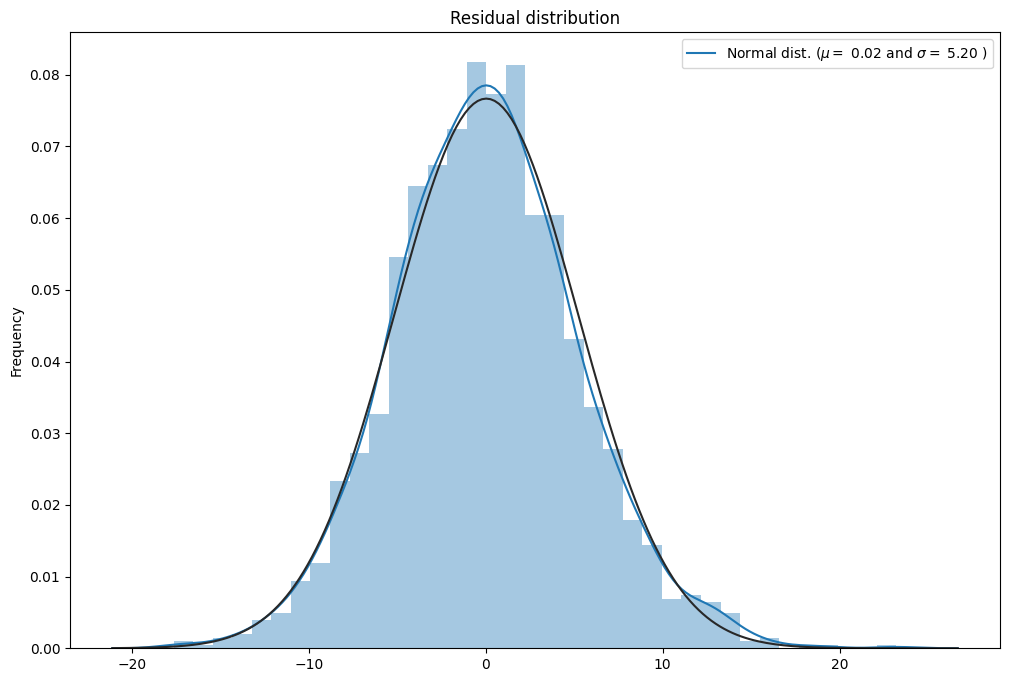

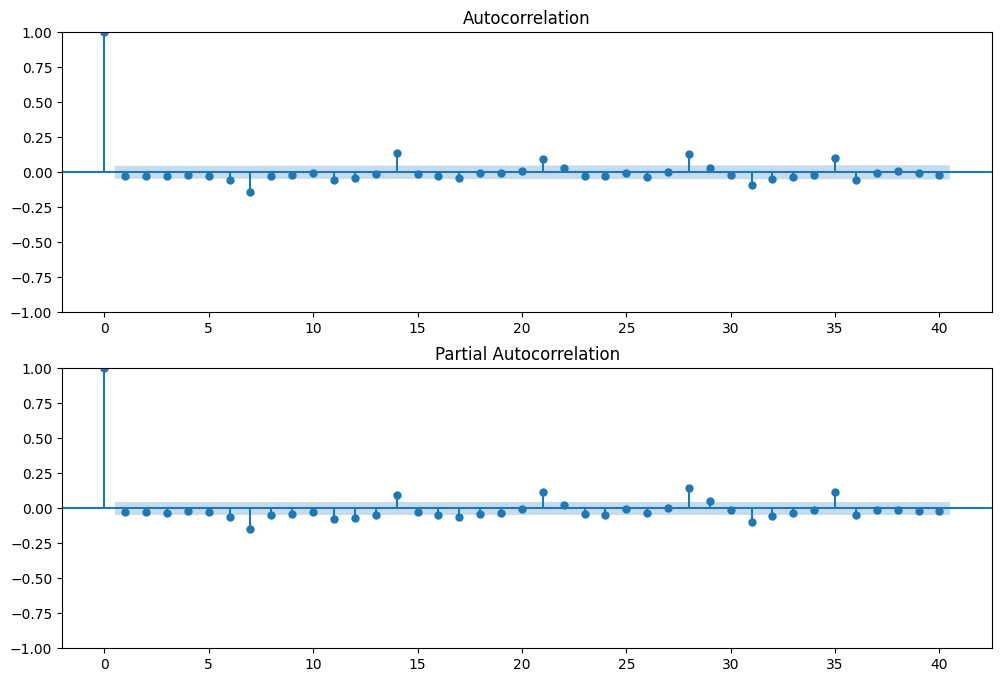

In [25]:
resid = sarima_model.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarima_model.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarima_model.resid, lags=40, ax=ax2)

## Prediction using SARIMA Model

Take the last 30 days in training set as validation data

<AxesSubplot:xlabel='date'>

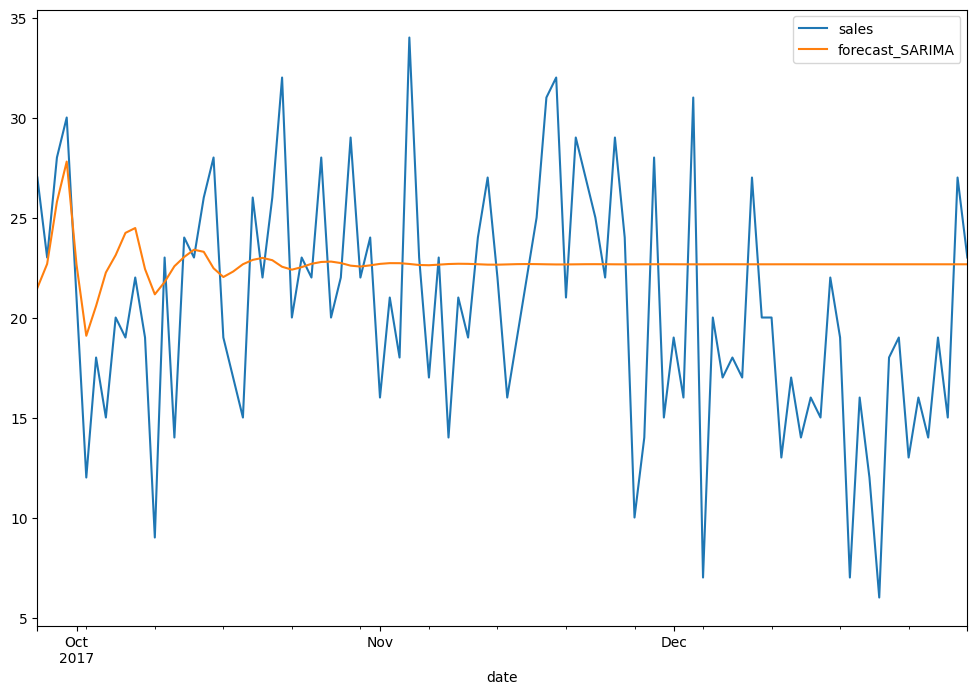

In [26]:
start_index = 1730
end_index = 1826
train_df['forecast_SARIMA'] = sarima_model.predict(start = start_index, end= end_index, dynamic= True)  
train_df[start_index:end_index][['sales', 'forecast_SARIMA']].plot(figsize=(12, 8))

We can see that this model is better than simple ARIMA model.

In [27]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

In [31]:
smape_kun(train_df[1730:1825]['sales'],train_df[1730:1825]['forecast_SARIMA'])

MAPE: 33.01 % 
SMAPE: 25.07 %


# Simple Exponential Smoothing (SES)

Simple Exponential Smoothing, is a time series forecasting method for univariate data **without a trend or seasonality**
<br> Since our model is a seasonal model so it cant be applied

In [29]:
'''from statsmodels.tsa.holtwinters import SimpleExpSmoothing
#fit the model
start_index = 1726
end_index = 1826

train_df['forecast_SES'] = SimpleExpSmoothing(train_df['sales']).fit().predict(start = start_index, end= end_index)
train_df[start_index:end_index][['sales', 'forecast_SES']].plot(figsize=(12, 8))
'''

"from statsmodels.tsa.holtwinters import SimpleExpSmoothing\n#fit the model\nstart_index = 1726\nend_index = 1826\n\ntrain_df['forecast_SES'] = SimpleExpSmoothing(train_df['sales']).fit().predict(start = start_index, end= end_index)\ntrain_df[start_index:end_index][['sales', 'forecast_SES']].plot(figsize=(12, 8))\n"

In [30]:
# smape_kun(train_df[1726:1826]['sales'],train_df[1726:1826]['forecast_SES'])